In [10]:
import os
from pathlib import Path
import sys
import time
from functools import partial
from tqdm import tqdm

pwd = Path(os.getcwd())
sys.path.append(str(pwd.parent.parent / "gym-checkers-for-thai"))

In [11]:
from checkers.agents.baselines import play_a_game, RandomPlayer
from checkers.game import Checkers
from checkers.agents import Player
from checkers.agents.alpha_beta import MinimaxPlayer, first_order_adv

from player import GADQNPlayer
from model import DQN

import pygad
import pygad.torchga
import torch

import numpy as np

In [12]:
MINIMAX_SEARCH_DEPTH = 2
WEIGHT_FOLDER = pwd / "weights" / f"vs_depth_{MINIMAX_SEARCH_DEPTH}"

In [13]:
# Create the folder if it doesn't exist
WEIGHT_FOLDER.mkdir(parents=True, exist_ok=True)

In [14]:
def run_experiment(model, n_matches=10, max_game_len=100, time_limit=10):
    n_wins, n_draws, n_losses = 0, 0, 0
    stime = time.time()

    # delete after end the loop
    looper = tqdm(range(n_matches), unit="matches", leave=False)
    for i in looper:
        ch = Checkers()

        # GA tuned model function
        black_player = GADQNPlayer('black', model=model)

        # Random player function
        # white_player = RandomPlayer('white', seed=i)

        # Minimax player function
        white_player = MinimaxPlayer('white', 
                                     partial(first_order_adv, 'white', 86, 54.5, 87, 26),
                                     search_depth=MINIMAX_SEARCH_DEPTH)
        

        #modify this function to put our RL model as white
        winner = play_a_game(ch, black_player.next_move, white_player.next_move, max_game_len, is_show_detail=False)

        # Keep scores
        n_wins += 1 if winner == 'black' else 0
        n_draws += 1 if winner is None else 0
        n_losses += 1 if winner == 'white' else 0

        looper.set_postfix(
            wins=n_wins,
            draws=n_draws,
            losses=n_losses,
        )
        
        if time.time() - stime > time_limit*60:
            break
    
    return n_wins, n_draws, n_losses

In [15]:
max_fitness_score = 0

def on_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Best fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))

def on_fitness(ga_instance, population_fitness):
    global max_fitness_score

    # save the best solution
    solution, best_fitness, _ = ga_instance.best_solution()

    if best_fitness > max_fitness_score:
        model = DQN()
        model_weights_dict = pygad.torchga.model_weights_as_dict(model=model, weights_vector=solution)
        model.load_state_dict(model_weights_dict)
        torch.save(model.state_dict(), f'{WEIGHT_FOLDER}/DQL_with_winrate{best_fitness*100:.2f}_generation{ga_instance.generations_completed}.pth')
        print("Model saved")
        max_fitness_score = best_fitness

In [16]:
def fitness_func(ga_instance, solution, solution_idx):

    model = DQN()
    model_weights_dict = pygad.torchga.model_weights_as_dict(model=model, weights_vector=solution)
    model.load_state_dict(model_weights_dict)

    n_wins, n_draws, n_losses = run_experiment(model, n_matches=55, max_game_len=100, time_limit=2)

    return n_wins/(n_wins+n_draws+n_losses)

In [17]:
torch_ga = pygad.torchga.TorchGA(model=DQN(),
                                 num_solutions=10)

ga_instance = pygad.GA(num_generations=100,
                       num_parents_mating=5,
                       initial_population = torch_ga.population_weights,
                       fitness_func=fitness_func,
                       parent_selection_type="sss",
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_percent_genes=15,
                       keep_parents=-1,
                       on_generation=on_generation,
                       on_fitness=on_fitness)

In [18]:
ga_instance.run()

  0%|          | 0/55 [00:00<?, ?matches/s]

Generation = 1


Best fitness = 0.01818181818181818


Model saved


Generation = 2


Best fitness = 0.01818181818181818


Model saved


Generation = 3


Best fitness = 0.01818181818181818


Generation = 4


Best fitness = 0.03636363636363636


Generation = 5


Best fitness = 0.03636363636363636


Generation = 6


Best fitness = 0.03636363636363636


Generation = 7


Best fitness = 0.03636363636363636


Generation = 8


Best fitness = 0.03636363636363636


Generation = 9


Best fitness = 0.03636363636363636


Generation = 10


Best fitness = 0.03636363636363636


Generation = 11


Best fitness = 0.05454545454545454


Generation = 12


Best fitness = 0.03636363636363636


Generation = 13


Best fitness = 0.03636363636363636


Generation = 14


Best fitness = 0.03636363636363636


Generation = 15


Best fitness = 0.05454545454545454


Model saved


Generation = 16


Best fitness = 0.05454545454545454


Generation = 17


Best fitness = 0.05454545454545454


Generation = 18


Best fitness = 0.05454545454545454


Generation = 19


Best fitness = 0.05454545454545454


Generation = 20


Best fitness = 0.05454545454545454


Model saved


Generation = 21


Best fitness = 0.05454545454545454


Generation = 22


Best fitness = 0.05454545454545454


Generation = 23


Best fitness = 0.05454545454545454


Generation = 24


Best fitness = 0.05454545454545454


Generation = 25


Best fitness = 0.05454545454545454


Generation = 26


Best fitness = 0.05454545454545454


Generation = 27


Best fitness = 0.05454545454545454


Generation = 28


Best fitness = 0.07272727272727272


Model saved


Generation = 29


Best fitness = 0.05454545454545454


Generation = 30


Best fitness = 0.07272727272727272


Generation = 31


Best fitness = 0.05454545454545454


Generation = 32


Best fitness = 0.05454545454545454


Generation = 33


Best fitness = 0.05454545454545454


KeyboardInterrupt: 

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [-0.51077613  0.20487465 -0.25741489 ... -0.81074191  0.41303005
 -0.46138888]
Fitness value of the best solution = 0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


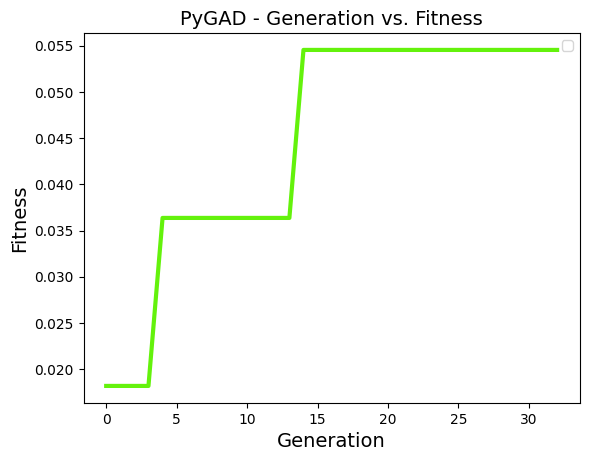

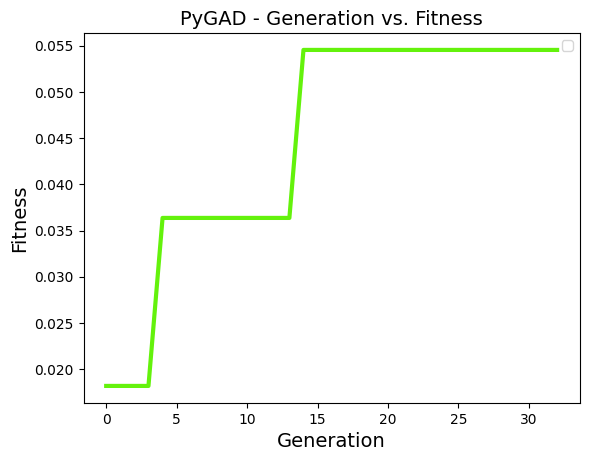

In [19]:
ga_instance.plot_fitness()

In [20]:
ga_instance.save('ga_instance')